In [85]:
# Imports
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from pyspark.sql import SparkSession, functions as F
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor


In [86]:
# PART 1: Spark aggregation to state-year (weighted rates/means)

BASE = "/Users/compiling/435Project/Project"
COMPLETE_DIR = Path(BASE) / "complete"

spark = SparkSession.builder.appName("Project").getOrCreate()

micro = spark.read.parquet(str(COMPLETE_DIR / "pums_*.parquet"))
print("Total micro rows (all years):", micro.count())

weight_col = 'PWGTP'
group_cols = ['STATE_NAME', 'YEAR']
wt_sum = F.sum(weight_col)

features = [
    wt_sum.alias('state_year_population'),
    F.first('TOTAL_HEALTH_SPENDING').alias('TOTAL_HEALTH_SPENDING'),

    # Demographics
    (F.sum(F.when(F.col('AGEP') >= 65, F.col(weight_col)).otherwise(0)) / wt_sum).alias('AGEP_65plus_share'),
    (F.sum(F.when(F.col('AGEP') <= 17, F.col(weight_col)).otherwise(0)) / wt_sum).alias('AGEP_0_17_share'),
    (F.sum(F.when(F.col('SEX') == 2, F.col(weight_col)).otherwise(0)) / wt_sum).alias('SEX_female_share'),
    (F.sum(F.when(F.col('MAR').isin(1, 2, 3), F.col(weight_col)).otherwise(0)) / wt_sum).alias('MAR_ever_married_share'),

    # Health insurance coverage
    (F.sum(F.when(F.col('HICOV') == 2, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HICOV_uninsured_share'),
    (F.sum(F.when(F.col('HINS1') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS1_employer_share'),
    (F.sum(F.when(F.col('HINS2') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS2_direct_share'),
    (F.sum(F.when(F.col('HINS3') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS3_medicare_share'),
    (F.sum(F.when(F.col('HINS4') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS4_medicaid_share'),
    (F.sum(F.when(F.col('HINS5') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS5_tricare_share'),
    (F.sum(F.when(F.col('HINS6') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS6_va_share'),

    # Economic & income
    (F.sum(F.when(F.col('POVPIP') < 138, F.col(weight_col)).otherwise(0)) / wt_sum).alias('POVPIP_lt138_share'),
    (F.sum(F.col('PINCP') * F.col(weight_col)) / wt_sum).alias('PINCP_mean'),
    (F.sum(F.col('WAGP') * F.col(weight_col)) / wt_sum).alias('WAGP_mean'),
    (F.sum(F.col('SEMP') * F.col(weight_col)) / F.sum(F.when(F.col('SEMP') > 0, F.col(weight_col)).otherwise(None))).alias('SEMP_mean_if_positive'),
    (F.sum(F.col('SSP') * F.col(weight_col)) / wt_sum).alias('SSP_per_capita'),
    (F.sum(F.when(F.col('RETP') > 0, F.col(weight_col)).otherwise(0)) / wt_sum).alias('RETP_positive_share'),

    # Employment & labor
    (F.sum(F.when(F.col('ESR').isin(3, 6), F.col(weight_col)).otherwise(0)) / wt_sum).alias('ESR_unemp_or_nilf_share'),
    (F.sum(F.when(F.col('ESR').isin(1, 2, 3, 4, 5), F.col(weight_col)).otherwise(0)) / wt_sum).alias('ESR_in_labor_force_share'),

    # Education & social
    (F.sum(F.when(F.col('SCHL') >= 21, F.col(weight_col)).otherwise(0)) / wt_sum).alias('SCHL_bach_plus_share'),
    (F.sum(F.when(F.col('DOUT') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('DOUT_diff_share'),
    (F.sum(F.when(F.col('DPHY') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('DPHY_diff_share'),
    (F.sum(F.when(F.col('DIS') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('DIS_any_share'),
    (
        1000.0
        * F.sum(
            F.when(
                (F.col('SEX') == 2) & (F.col('AGEP').between(15, 50)) & (F.col('FER') == 1),
                F.col(weight_col),
            ).otherwise(0)
        )
        / F.sum(F.when((F.col('SEX') == 2) & (F.col('AGEP').between(15, 50)), F.col(weight_col)).otherwise(None))
    ).alias('FER_births_per_1000_women_15_50'),

    # Access & lifestyle
    (F.sum(F.when(F.col('BROADBND') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('BROADBND_yes_share'),
    (F.sum(F.col('VEH') * F.col(weight_col)) / wt_sum).alias('VEH_mean_per_person'),
    (F.sum(F.when(F.col('MIL').isin(2, 3), F.col(weight_col)).otherwise(0)) / wt_sum).alias('MIL_veteran_share'),
    (F.sum(F.when(F.col('MIL') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('MIL_active_duty_share'),
]

print("Aggregating microdata to state-year panel ...")
df_state_year = (
    micro
    .groupBy(*group_cols)
    .agg(*features)
    .toPandas()
)
print('Final panel shape:', df_state_year.shape)
df_state_year.head()


25/12/03 19:52:05 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: /Users/compiling/435Project/Project/complete/pums_*.parquet.
java.io.FileNotFoundException: File /Users/compiling/435Project/Project/complete/pums_*.parquet does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSource$$loadV1BatchSource(Resol

Total micro rows (all years): 15912393
Aggregating microdata to state-year panel ...
Final panel shape: (255, 32)


,STATE_NAME,YEAR,state_year_population,TOTAL_HEALTH_SPENDING,AGEP_65plus_share,AGEP_0_17_share,SEX_female_share,MAR_ever_married_share,HICOV_uninsured_share,HINS1_employer_share,...,ESR_in_labor_force_share,SCHL_bach_plus_share,DOUT_diff_share,DPHY_diff_share,DIS_any_share,FER_births_per_1000_women_15_50,BROADBND_yes_share,VEH_mean_per_person,MIL_veteran_share,MIL_active_duty_share
0,Georgia,2023,11029227,7984.0,0.153987,0.229787,0.512272,0.510425,0.118536,0.522321,...,0.513037,0.249936,0.048654,0.066701,0.138376,50.980524,0.882308,2.146883,0.063762,0.005160
1,New Jersey,2023,9290841,9676.0,0.177698,0.216073,0.507687,0.521444,0.071422,0.598993,...,0.541512,0.326099,0.045048,0.054495,0.112192,51.128098,0.902386,1.919621,0.034651,0.000931
2,Minnesota,2021,5707390,8686.0,0.168798,0.228722,0.499954,0.533945,0.043775,0.609255,...,0.547687,0.277308,0.047489,0.050248,0.124941,56.288797,0.875737,2.168501,0.059511,0.000425
3,Kansas,2023,2940547,8502.0,0.176232,0.233088,0.497563,0.549769,0.083518,0.573489,...,0.526105,0.253048,0.050902,0.065071,0.146462,55.325867,0.865346,2.234180,0.061661,0.008434
4,Utah,2021,3337975,5734.0,0.116340,0.282819,0.492425,0.517114,0.093118,0.633758,...,0.516075,0.227447,0.034616,0.040597,0.106772,59.919620,0.897629,2.513679,0.044944,0.002226


In [ ]:

# PART 2: Pooled RF model (per-capita target, shuffled split 70/20/10)

# Verify target uniqueness per state-year
leakage_counts = df_state_year.groupby(['STATE_NAME', 'YEAR'])['TOTAL_HEALTH_SPENDING'].nunique()
print('Target nunique per state-year:')
print(leakage_counts.value_counts().sort_index())
print('Summary:')
print(leakage_counts.describe())

target = 'TOTAL_HEALTH_SPENDING'  # per-capita dollars
categorical_cols = []  # drop STATE_NAME for pooled drivers
drop_from_X = {
    target, 'STATE_NAME', 'ST', 'state_year_population',
    'SSP_per_capita', 'RETP_positive_share',
    'DOUT_diff_share', 'DPHY_diff_share',
}
numeric_cols = [c for c in df_state_year.columns if c not in drop_from_X]

X_full = df_state_year[categorical_cols + numeric_cols]
y_full = df_state_year[target]

# 70/20/10 split
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X_full, y_full, test_size=0.10, random_state=42, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.20, random_state=42, shuffle=True
)
print(f'Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}')

preprocess = ColumnTransformer([
    ('num', 'passthrough', numeric_cols),
])

def eval_split(name, y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> R^2: {r2:,.3f} | MAE: {mae:,.2f} | RMSE: {rmse:,.2f}")
    return r2, mae, rmse

# Simple grid over a few RF hyperparameters, tuned on the validation set
from itertools import product
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [10, 15],
    'min_samples_leaf': [1, 2],
}
results = []
best_rmse = None
best_pipe = None
best_params = None
for n_est, depth, leaf in product(param_grid['n_estimators'], param_grid['max_depth'], param_grid['min_samples_leaf']):
    rf = RandomForestRegressor(
        n_estimators=n_est,
        max_depth=depth,
        min_samples_leaf=leaf,
        n_jobs=-1,
        random_state=42,
    )
    pipe_candidate = Pipeline([('pre', preprocess), ('rf', rf)])
    pipe_candidate.fit(X_train, y_train)
    val_pred = pipe_candidate.predict(X_val)
    r2, mae, rmse = eval_split(f'Val (n={n_est}, depth={depth}, leaf={leaf})', y_val, val_pred)
    results.append((rmse, n_est, depth, leaf, r2, mae))
    if best_rmse is None or rmse < best_rmse:
        best_rmse = rmse
        best_pipe = pipe_candidate
        best_params = {'n_estimators': n_est, 'max_depth': depth, 'min_samples_leaf': leaf}

print('Best params (val RMSE):', best_params)
print(f"Best val RMSE: {best_rmse:,.2f}")

# Refit best model on train+val, evaluate on test only 
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])
best_pipe.fit(X_trainval, y_trainval)
y_pred = best_pipe.predict(X_test)
test_r2, test_mae, test_rmse = eval_split('Test (best model)', y_test, y_pred)

# Use best_pipe for downstream steps
pipe = best_pipe


Target nunique per state-year:
TOTAL_HEALTH_SPENDING
1    255
Name: count, dtype: int64
Summary:
count    255.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: TOTAL_HEALTH_SPENDING, dtype: float64
Train: 183, Val: 46, Test: 26
Val (n=300, depth=10, leaf=1) -> R^2: 0.661 | MAE: 611.82 | RMSE: 771.06
Val (n=300, depth=10, leaf=2) -> R^2: 0.648 | MAE: 621.84 | RMSE: 785.66
Val (n=300, depth=15, leaf=1) -> R^2: 0.661 | MAE: 609.29 | RMSE: 770.93
Val (n=300, depth=15, leaf=2) -> R^2: 0.646 | MAE: 621.23 | RMSE: 788.10
Val (n=500, depth=10, leaf=1) -> R^2: 0.669 | MAE: 603.81 | RMSE: 762.28
Val (n=500, depth=10, leaf=2) -> R^2: 0.654 | MAE: 616.85 | RMSE: 779.70
Val (n=500, depth=15, leaf=1) -> R^2: 0.672 | MAE: 598.62 | RMSE: 759.26
Val (n=500, depth=15, leaf=2) -> R^2: 0.651 | MAE: 616.76 | RMSE: 782.35
Best params (val RMSE): {'n_estimators': 500, 'max_depth': 15, 'min_samples_leaf': 1}
Best val RMSE: 759.26
Test (best model)

In [88]:
# 5-fold cross-validation on pooled RF pipeline (full data)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error',
}
cv_res = cross_validate(
    pipe, X_full, y_full, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
)
mean_r2 = cv_res['test_r2'].mean()
std_r2 = cv_res['test_r2'].std()
mean_mae = (-cv_res['test_mae']).mean()
mean_rmse = (-cv_res['test_rmse']).mean()
print(f"5-fold CV -> R^2: {mean_r2:.3f} +/- {std_r2:.3f} | MAE: {mean_mae:,.2f} | RMSE: {mean_rmse:,.2f}")

5-fold CV -> R^2: 0.737 +/- 0.030 | MAE: 547.50 | RMSE: 722.25


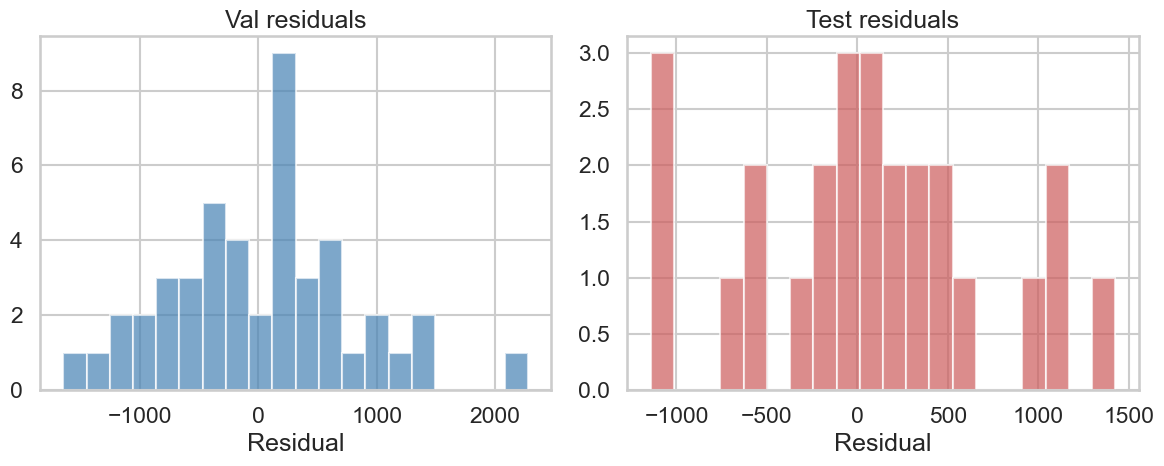

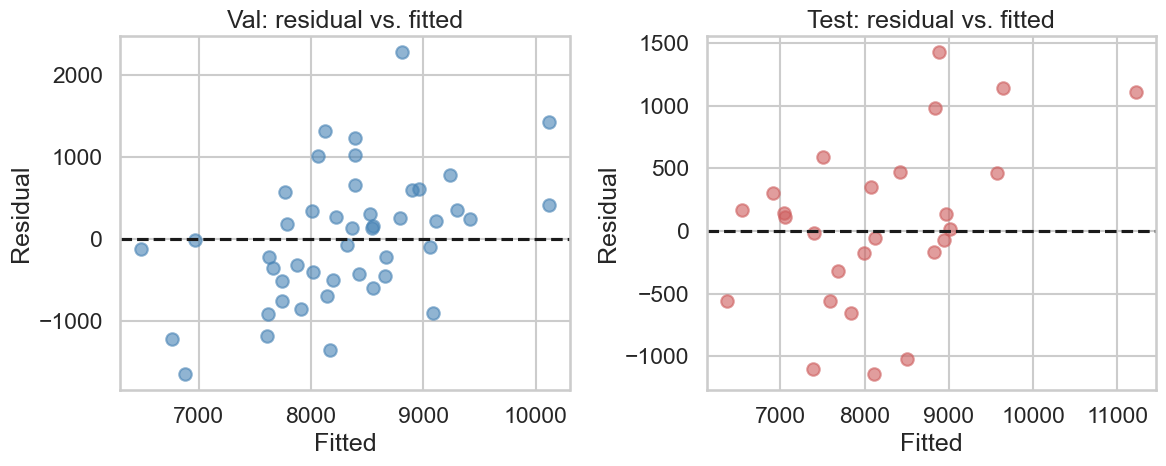

In [89]:

# Residual analysis (val/test)
if 'y_pred' not in globals() or 'y_test' not in globals() or 'val_pred' not in globals():
    print('Need y_pred/y_test and val_pred/y_val from the tuned model; run the RF cell first.')
else:
    # Residuals
    val_resid = y_val - val_pred
    test_resid = y_test - y_pred
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].hist(val_resid, bins=20, alpha=0.7, color='steelblue')
    axes[0].set_title('Val residuals')
    axes[0].set_xlabel('Residual')
    axes[1].hist(test_resid, bins=20, alpha=0.7, color='indianred')
    axes[1].set_title('Test residuals')
    axes[1].set_xlabel('Residual')
    plt.tight_layout()
    plt.show()

    # Residual vs. fitted
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].scatter(val_pred, val_resid, alpha=0.6, color='steelblue')
    axes[0].axhline(0, color='k', linestyle='--')
    axes[0].set_title('Val: residual vs. fitted')
    axes[0].set_xlabel('Fitted')
    axes[0].set_ylabel('Residual')

    axes[1].scatter(y_pred, test_resid, alpha=0.6, color='indianred')
    axes[1].axhline(0, color='k', linestyle='--')
    axes[1].set_title('Test: residual vs. fitted')
    axes[1].set_xlabel('Fitted')
    axes[1].set_ylabel('Residual')
    plt.tight_layout()
    plt.show()


In [90]:
# PART 2b: Random Forest feature importances

if hasattr(pipe, 'named_steps') and 'rf' in pipe.named_steps:

    rf_model = pipe.named_steps['rf']
    importances = rf_model.feature_importances_
    fi = pd.DataFrame({
        'feature': numeric_cols,
        'importance': importances,
    }).sort_values('importance', ascending=False)
    print('Top 15 feature importances:')
    print(fi.head(15).to_string(index=False))
else:
    print('RandomForestRegressor not found in pipeline; skipping importances')


Top 15 feature importances:
                 feature  importance
   HICOV_uninsured_share    0.162836
              PINCP_mean    0.146875
     VEH_mean_per_person    0.075883
                    YEAR    0.063068
   SEMP_mean_if_positive    0.059283
          HINS6_va_share    0.053761
        SEX_female_share    0.045783
      HINS2_direct_share    0.041841
ESR_in_labor_force_share    0.039246
         AGEP_0_17_share    0.038137
    HINS3_medicare_share    0.036519
    HINS4_medicaid_share    0.034043
       AGEP_65plus_share    0.029797
 ESR_unemp_or_nilf_share    0.023355
  MAR_ever_married_share    0.016044


In [91]:
# PART 2c: Top 5 feature importances per year (separate RF per year)

years = sorted(df_state_year['YEAR'].unique())
print('Per-year RF importances (top 5):')

for yr in years:
    df_y = df_state_year[df_state_year['YEAR'] == yr].copy()
    if df_y.shape[0] < 10:
        print(f'Year {yr}: skipped (too few rows: {df_y.shape[0]})')
        continue

    X_y = df_y[numeric_cols]
    y_y = df_y[target]

    rf_y = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        n_jobs=-1,
        random_state=42,
    )
    rf_y.fit(X_y, y_y)

    fi = pd.DataFrame({
        'feature': numeric_cols,
        'importance': rf_y.feature_importances_,
    }).sort_values('importance', ascending=False).head(5)
    print(f'Year {yr} (rows={len(df_y)}):')
    print(fi.to_string(index=False))
 


Per-year RF importances (top 5):
Year 2019 (rows=51):
                 feature  importance
   HICOV_uninsured_share    0.210674
ESR_in_labor_force_share    0.112111
     VEH_mean_per_person    0.074775
              PINCP_mean    0.067612
         AGEP_0_17_share    0.064631
Year 2020 (rows=51):
                 feature  importance
ESR_in_labor_force_share    0.164571
   HICOV_uninsured_share    0.132387
     VEH_mean_per_person    0.086119
         AGEP_0_17_share    0.075815
              PINCP_mean    0.056550
Year 2021 (rows=51):
              feature  importance
HICOV_uninsured_share    0.193307
           PINCP_mean    0.146944
  VEH_mean_per_person    0.103873
     SEX_female_share    0.058213
 HINS3_medicare_share    0.055018
Year 2022 (rows=51):
               feature  importance
 HICOV_uninsured_share    0.219292
 SEMP_mean_if_positive    0.137199
   VEH_mean_per_person    0.087491
     AGEP_65plus_share    0.051615
MAR_ever_married_share    0.044848
Year 2023 (rows=51):
    

In [92]:
# scikit-optimize install (run manually if needed):
# %pip install scikit-optimize


In [93]:

# XGBoost baseline model
X = df_state_year[numeric_cols]
y = df_state_year[target]
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    objective='reg:squarederror',
)

xgb.fit(X_train_x, y_train_x)

for name, yt, yp in [('Train', y_train_x, xgb.predict(X_train_x)), ('Test', y_test_x, xgb.predict(X_test_x))]:
    rmse = root_mean_squared_error(yt, yp)
    mae = mean_absolute_error(yt, yp)
    r2 = r2_score(yt, yp)
    print(f"{name} -> RMSE: {rmse:,.2f}  MAE: {mae:,.2f}  R^2: {r2:.3f}")

xgb_baseline_model = xgb
y_pred_xgb = xgb.predict(X_test_x)


Train -> RMSE: 0.12  MAE: 0.09  R^2: 1.000
Test -> RMSE: 634.48  MAE: 499.36  R^2: 0.812


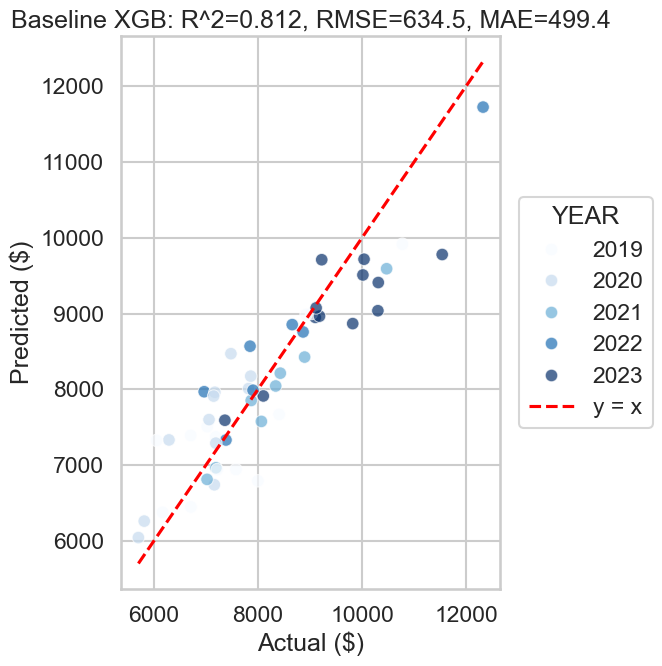

In [94]:
sns.set_theme(style="whitegrid", context="talk")

if 'xgb_baseline_model' in globals():
    rmse = root_mean_squared_error(y_test_x, y_pred_xgb)
    mae = mean_absolute_error(y_test_x, y_pred_xgb)
    r2 = r2_score(y_test_x, y_pred_xgb)
    plt.figure(figsize=(7,7))
    sns.scatterplot(x=y_test_x, y=y_pred_xgb,
                    hue=X_test_x['YEAR'] if 'YEAR' in X_test_x else None,
                    palette='Blues', alpha=0.7)
    lo, hi = min(y_test_x.min(), y_pred_xgb.min()), max(y_test_x.max(), y_pred_xgb.max())
    plt.plot([lo, hi], [lo, hi], color='red', linestyle='--', label='y = x')
    plt.xlabel('Actual ($)')
    plt.ylabel('Predicted ($)')
    plt.title(f'Baseline XGB: R^2={r2:.3f}, RMSE={rmse:,.1f}, MAE={mae:,.1f}')
    plt.legend(title='YEAR', bbox_to_anchor=(1.02, 0.5), loc='center left')
    plt.tight_layout()
    plt.show()
else:
    print('XGB baseline not available in this environment')



In [95]:
top_n = 5

target_col = 'TOTAL_HEALTH_SPENDING'
if 'target' in globals():
    target_col = target

top_feat_by_year = {}
if 'df_state_year' not in globals() or 'numeric_cols' not in globals():
    print('Run the prep cell first to define df_state_year and numeric_cols.')
elif target_col not in df_state_year.columns:
    print(f"Target column '{target_col}' not found in df_state_year.")
else:
    for yr in sorted(df_state_year['YEAR'].unique()):
        df_y = df_state_year[df_state_year['YEAR'] == yr]
        if df_y.shape[0] < 10:
            continue
        X_y = df_y[numeric_cols]
        y_y = df_y[target_col]
        rf_y = RandomForestRegressor(
            n_estimators=300,
            max_depth=10,
            n_jobs=-1,
            random_state=42,
        )
        rf_y.fit(X_y, y_y)
        s = pd.Series(rf_y.feature_importances_, index=numeric_cols).nlargest(top_n)
        top_feat_by_year[yr] = ', '.join([f"{feat} ({imp:.3f})" for feat, imp in s.items()])
    if top_feat_by_year:
        print(f'Computed top {top_n} features for {len(top_feat_by_year)} years.')
    else:
        print('No per-year importances computed (too few rows or data issues).')


Computed top 5 features for 5 years.


In [96]:

# Animated choropleth over years (hover shows precomputed top-5 per-year RF features)
metric_col = 'TOTAL_HEALTH_SPENDING'  # change to any numeric column in df_state_year
color_range = None  # optionally set (min, max) for consistent scale across years

target_top_n = globals().get('top_n', 5)
STATE_TO_ABBR = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
    'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA',
    'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
}

if 'df_state_year' not in globals() or 'numeric_cols' not in globals():
    print('df_state_year or numeric_cols missing; run the prep cell first.')
elif 'YEAR' not in df_state_year.columns:
    print("Column 'YEAR' missing in df_state_year; cannot animate.")
elif metric_col not in df_state_year.columns:
    print(f"Column {metric_col} not in df_state_year; choose another metric_col.")
else:
    df_plot = df_state_year.copy()
    if 'ST' not in df_plot.columns and 'STATE_NAME' in df_plot.columns:
        df_plot['ST'] = df_plot['STATE_NAME'].map(STATE_TO_ABBR)
    if 'ST' not in df_plot.columns:
        print("Need 'ST' or 'STATE_NAME' to map to state codes before plotting.")
    else:
        df_plot = df_plot.dropna(subset=['ST', metric_col, 'YEAR'])
        if df_plot.empty:
            print('No data after cleaning for ST/metric/YEAR.')
        else:
            if 'top_feat_by_year' in globals():
                df_plot['top_features'] = df_plot['YEAR'].map(top_feat_by_year).fillna('n/a')
            else:
                df_plot['top_features'] = 'n/a (run precompute cell)'

            if color_range is None:
                color_range = (df_plot[metric_col].min(), df_plot[metric_col].max())
            fig = px.choropleth(
                df_plot,
                locations='ST',
                locationmode='USA-states',
                color=metric_col,
                hover_name='STATE_NAME' if 'STATE_NAME' in df_plot.columns else 'ST',
                hover_data={'top_features': True},
                scope='usa',
                color_continuous_scale='Blues',
                animation_frame='YEAR',
                labels={metric_col: metric_col.replace('_', ' '), 'top_features': f'Top {target_top_n} features'},
                range_color=color_range,
                height=550,
            )
            fig.update_layout(title=f"{metric_col.replace('_', ' ')} by state (animated) — hover for top {target_top_n} features")
            fig.update_layout(transition={'duration': 0})
            years_sorted = sorted(df_plot['YEAR'].unique())
            fig.update_layout(
                updatemenus=[{
                    'type': 'buttons',
                    'showactive': True,
                    'x': 1.05,
                    'y': 1.15,
                    'buttons': [
                        {
                            'label': 'Play',
                            'method': 'animate',
                            'args': [None, {
                                'frame': {'duration': 800, 'redraw': True},
                                'transition': {'duration': 0},
                                'fromcurrent': True,
                            }]
                        },
                        {
                            'label': 'Pause',
                            'method': 'animate',
                            'args': [[None], {
                                'frame': {'duration': 0, 'redraw': False},
                                'mode': 'immediate',
                            }]
                        }
                    ]
                }],
                sliders=[{
                    'pad': {'t': 50},
                    'x': 0.1,
                    'len': 0.8,
                    'currentvalue': {'prefix': 'Year: '},
                    'steps': [
                        {
                            'label': str(yr),
                            'method': 'animate',
                            'args': [[str(yr)], {'mode': 'immediate', 'frame': {'duration': 0, 'redraw': True}, 'transition': {'duration': 0}}]
                        }
                        for yr in years_sorted
                    ],
                }]
            )

            out_path = 'choropleth_anim.html'
            fig.write_html(out_path, include_plotlyjs='cdn', full_html=True)
            print(f'Wrote animated choropleth to {out_path}')
            from IPython.display import HTML, display
            display(HTML(fig.to_html(include_plotlyjs='cdn', full_html=False)))


Wrote animated choropleth to choropleth_anim.html
